In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Set local paths
images_path = "./images"
res_path = "./data/losses"

# Dataset

## Loading and preprocessing

In [4]:
#%%Loading the dataset 

min_len = 10
dataset = Mobydick('./data/mobydick.txt', min_len = min_len)

with open('./data/clean_text', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    
len(dataset)

466

In [5]:
# Given a min_len>2, it is not necessary to delete the chapters titles
print(dataset[0])

['some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']


Mean sentence length: 30.446351931330472
Max sentence length: 127
Min sentence length: 10


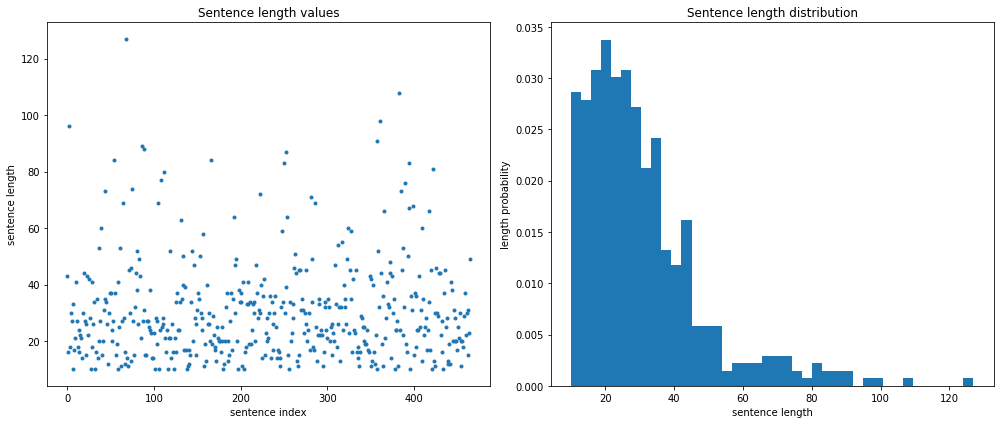

In [6]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/md_{min_len}.png')
plt.show()

In [7]:
print(len(dataset.words))

2986


## Word embeddings

In [8]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [9]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [10]:
crop_len = 10

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToIndex(words),
    ToTensor()
])

In [11]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([10])

# LSTM

In [12]:
params = {
        # network
        'hidden_units' : 2**9, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.3,
        'architecture' : 'GRU',

        # training
        'batch_size' : 80,
        'num_epochs' : 1000,

        # optimizer
        'lr' : 1e-2,
        'wd' : 1e-3,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = '{}_{}_{}_{}_{}'.format(params['architecture'], params['crop_len'], params['min_len'], params['lr'],params['wd'])

In [13]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [14]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = params['architecture'],
              trained_embeddings = vectors,
              freeze_embeddings = False,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
loss_fn = nn.MSELoss()

net.to(device)

Network(
  (rnn): GRU(50, 512, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=512, out_features=50, bias=True)
  (embed): Embedding(2998, 50)
)

In [ ]:
%%time

#%% Train network

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(params['num_epochs']):
    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    with torch.no_grad():
        for batch_sample in test_dataloader:
            batch = batch_sample.long().to(device)
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params }

# Save losses dictionary
with open(res_path + "/" + out_dir, 'wb') as f:
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)
    
# Save model 
torch.save(net.state_dict(), res_path + "/state_" + out_dir + '.pth')



 EPOCH 1/1000
	 Training loss (epoch - mean):  2.9606871555248895
	 Validation loss (epoch - mean): 0.9468319771137643


 EPOCH 2/1000
	 Training loss (epoch - mean):  0.6670250544945399
	 Validation loss (epoch - mean): 0.4282228582082911


 EPOCH 3/1000
	 Training loss (epoch - mean):  0.3389662404855092
	 Validation loss (epoch - mean): 0.31637389735972626


 EPOCH 4/1000
	 Training loss (epoch - mean):  0.25268485645453137
	 Validation loss (epoch - mean): 0.23679912962177965


 EPOCH 5/1000
	 Training loss (epoch - mean):  0.20766486724217734
	 Validation loss (epoch - mean): 0.21024132615074198


 EPOCH 6/1000
	 Training loss (epoch - mean):  0.18313078582286835
	 Validation loss (epoch - mean): 0.19108848931624534


 EPOCH 7/1000
	 Training loss (epoch - mean):  0.16882625967264175
	 Validation loss (epoch - mean): 0.16747795830064632


 EPOCH 8/1000
	 Training loss (epoch - mean):  0.15600261837244034
	 Validation loss (epoch - mean): 0.16039612104601048


 EPOCH 9/1000
	 Tra

	 Training loss (epoch - mean):  0.0193220735527575
	 Validation loss (epoch - mean): 0.01663304848517192


 EPOCH 68/1000
	 Training loss (epoch - mean):  0.015862147323787212
	 Validation loss (epoch - mean): 0.018795486301817793


 EPOCH 69/1000
	 Training loss (epoch - mean):  0.01524507331972321
	 Validation loss (epoch - mean): 0.011632358348195223


 EPOCH 70/1000
	 Training loss (epoch - mean):  0.012548403659214577
	 Validation loss (epoch - mean): 0.02141856875746174


 EPOCH 71/1000
	 Training loss (epoch - mean):  0.08024212097128232
	 Validation loss (epoch - mean): 0.06928133385929655


 EPOCH 72/1000
	 Training loss (epoch - mean):  0.038266551991303764
	 Validation loss (epoch - mean): 0.018319872128678128


 EPOCH 73/1000
	 Training loss (epoch - mean):  0.021373160183429718
	 Validation loss (epoch - mean): 0.018907380944236794


 EPOCH 74/1000
	 Training loss (epoch - mean):  0.014932372607290745
	 Validation loss (epoch - mean): 0.01565089177815838


 EPOCH 75/1000


	 Training loss (epoch - mean):  0.0009179162152577192
	 Validation loss (epoch - mean): 0.0012367240377453197


 EPOCH 133/1000
	 Training loss (epoch - mean):  0.0008366680218993375
	 Validation loss (epoch - mean): 0.0005841651636341765


 EPOCH 134/1000
	 Training loss (epoch - mean):  0.0008173397412368407
	 Validation loss (epoch - mean): 0.0005386359910546085


 EPOCH 135/1000
	 Training loss (epoch - mean):  0.0007596941334971538
	 Validation loss (epoch - mean): 0.0004438534982029446


 EPOCH 136/1000
	 Training loss (epoch - mean):  0.0006809856665010253
	 Validation loss (epoch - mean): 0.0007682421019319705


 EPOCH 137/1000
	 Training loss (epoch - mean):  0.000742320844437927
	 Validation loss (epoch - mean): 0.000841323606550759


 EPOCH 138/1000
	 Training loss (epoch - mean):  0.0005645648003943885
	 Validation loss (epoch - mean): 0.0005485700899140632


 EPOCH 139/1000
	 Training loss (epoch - mean):  0.0006681706581730396
	 Validation loss (epoch - mean): 0.00054444

	 Training loss (epoch - mean):  2.750665438118934e-05
	 Validation loss (epoch - mean): 1.4307419221758418e-05


 EPOCH 197/1000
	 Training loss (epoch - mean):  2.6516609674824092e-05
	 Validation loss (epoch - mean): 3.2084140679836175e-05


 EPOCH 198/1000
	 Training loss (epoch - mean):  2.583067407613271e-05
	 Validation loss (epoch - mean): 2.7829167364304938e-05


 EPOCH 199/1000
	 Training loss (epoch - mean):  2.418024208357868e-05
	 Validation loss (epoch - mean): 2.792768204406631e-05


 EPOCH 200/1000
	 Training loss (epoch - mean):  2.2394652660295833e-05
	 Validation loss (epoch - mean): 2.0001885916480824e-05


 EPOCH 201/1000
	 Training loss (epoch - mean):  2.0549467232437262e-05
	 Validation loss (epoch - mean): 2.8814642394414195e-05


 EPOCH 202/1000
	 Training loss (epoch - mean):  2.2176334975180605e-05
	 Validation loss (epoch - mean): 2.3152628203392657e-05


 EPOCH 203/1000
	 Training loss (epoch - mean):  1.965618654746019e-05
	 Validation loss (epoch - mean)

	 Training loss (epoch - mean):  3.1225988313584213e-07
	 Validation loss (epoch - mean): 1.2158572034997086e-07


 EPOCH 261/1000
	 Training loss (epoch - mean):  3.134013108289461e-07
	 Validation loss (epoch - mean): 1.4664430960559132e-07


 EPOCH 262/1000
	 Training loss (epoch - mean):  2.626732099978805e-07
	 Validation loss (epoch - mean): 1.201161978580986e-07


 EPOCH 263/1000
	 Training loss (epoch - mean):  2.2988339765106502e-07
	 Validation loss (epoch - mean): 3.422684847977352e-07


 EPOCH 264/1000
	 Training loss (epoch - mean):  2.4598672787590203e-07
	 Validation loss (epoch - mean): 1.8237902588029284e-07


 EPOCH 265/1000
	 Training loss (epoch - mean):  1.8219168633019459e-07
	 Validation loss (epoch - mean): 4.0097091317933286e-07


 EPOCH 266/1000
	 Training loss (epoch - mean):  1.871260527271564e-07
	 Validation loss (epoch - mean): 1.1654429703747002e-07


 EPOCH 267/1000
	 Training loss (epoch - mean):  1.7325558706223396e-07
	 Validation loss (epoch - mean)

	 Validation loss (epoch - mean): 9.01310639108885e-10


 EPOCH 324/1000
	 Training loss (epoch - mean):  1.748397251051988e-09
	 Validation loss (epoch - mean): 9.15108256722007e-10


 EPOCH 325/1000
	 Training loss (epoch - mean):  2.0684932655612442e-09
	 Validation loss (epoch - mean): 3.4614038010228535e-09


 EPOCH 326/1000
	 Training loss (epoch - mean):  8.530761351951041e-10
	 Validation loss (epoch - mean): 5.049472265018194e-09


 EPOCH 327/1000
	 Training loss (epoch - mean):  1.4992932959959997e-09
	 Validation loss (epoch - mean): 8.697549008093711e-10


 EPOCH 328/1000
	 Training loss (epoch - mean):  2.872333001076773e-09
	 Validation loss (epoch - mean): 1.283796048560671e-10


 EPOCH 329/1000
	 Training loss (epoch - mean):  5.54578979961029e-10
	 Validation loss (epoch - mean): 3.736215431969591e-09


 EPOCH 330/1000
	 Training loss (epoch - mean):  1.6652703105357602e-09
	 Validation loss (epoch - mean): 2.520846021397978e-10


 EPOCH 331/1000
	 Training loss (epoch

	 Training loss (epoch - mean):  3.522654610411466e-11
	 Validation loss (epoch - mean): 7.511870360252132e-10


 EPOCH 388/1000
	 Training loss (epoch - mean):  4.0323168555444294e-11
	 Validation loss (epoch - mean): 8.656957988047458e-11


 EPOCH 389/1000
	 Training loss (epoch - mean):  1.5424387348777758e-11
	 Validation loss (epoch - mean): 2.8557465091898656e-10


 EPOCH 390/1000
	 Training loss (epoch - mean):  4.931087439868255e-11
	 Validation loss (epoch - mean): 4.727893321438557e-13


 EPOCH 391/1000
	 Training loss (epoch - mean):  5.514822358903641e-13
	 Validation loss (epoch - mean): 4.857399493851057e-13


 EPOCH 392/1000
	 Training loss (epoch - mean):  1.8235277852967035e-11
	 Validation loss (epoch - mean): 2.3563642626391885e-13


 EPOCH 393/1000
	 Training loss (epoch - mean):  2.399274084529529e-13
	 Validation loss (epoch - mean): 1.89396939970888e-13


 EPOCH 394/1000
	 Training loss (epoch - mean):  4.243801662668741e-11
	 Validation loss (epoch - mean): 8.44

	 Validation loss (epoch - mean): 4.1040652365870466e-11


 EPOCH 451/1000
	 Training loss (epoch - mean):  1.430385048542153e-13
	 Validation loss (epoch - mean): 1.3637906590541634e-12


 EPOCH 452/1000
	 Training loss (epoch - mean):  6.45446193797126e-14
	 Validation loss (epoch - mean): 4.0566431615506515e-14


 EPOCH 453/1000
	 Training loss (epoch - mean):  2.397234568864744e-13
	 Validation loss (epoch - mean): 1.4914633391420271e-12


 EPOCH 454/1000
	 Training loss (epoch - mean):  1.12602489330068e-13
	 Validation loss (epoch - mean): 5.672690718614532e-10


 EPOCH 455/1000
	 Training loss (epoch - mean):  1.0370860369687496e-13
	 Validation loss (epoch - mean): 1.2848130755621229e-15


 EPOCH 456/1000
	 Training loss (epoch - mean):  4.843585497964281e-14
	 Validation loss (epoch - mean): 2.8444926632548687e-13


 EPOCH 457/1000
	 Training loss (epoch - mean):  4.4059894441645227e-14
	 Validation loss (epoch - mean): 4.509756246988989e-11


 EPOCH 458/1000
	 Training loss (

	 Training loss (epoch - mean):  3.221364589523025e-15
	 Validation loss (epoch - mean): 2.2629984836893835e-15


 EPOCH 515/1000
	 Training loss (epoch - mean):  1.2440671387205217e-15
	 Validation loss (epoch - mean): 1.671922131364354e-13


 EPOCH 516/1000
	 Training loss (epoch - mean):  1.5927341246157903e-12
	 Validation loss (epoch - mean): 8.836086664304852e-13


 EPOCH 517/1000
	 Training loss (epoch - mean):  2.409875279964403e-15
	 Validation loss (epoch - mean): 3.524718843560303e-09


 EPOCH 518/1000
	 Training loss (epoch - mean):  1.2253099073293006e-15
	 Validation loss (epoch - mean): 3.580338444473969e-09


 EPOCH 519/1000
	 Training loss (epoch - mean):  9.24353229290406e-16
	 Validation loss (epoch - mean): 4.0730866554411e-11


 EPOCH 520/1000
	 Training loss (epoch - mean):  4.831739035233233e-16
	 Validation loss (epoch - mean): 1.3332601266784549e-15


 EPOCH 521/1000
	 Training loss (epoch - mean):  4.9934474352261436e-17
	 Validation loss (epoch - mean): 4.127

In [ ]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path + "/model_losses_"  + out_dir +".png")
plt.show()

# Text generation

In [ ]:
# Set seed
seed = 'When you are alone in the middle of the sea'

In [ ]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)
# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

# Load hyperparameters
with open(res_path + "/" + out_dir, 'rb') as f:
    params = pickle.load(f)
    params = params['params']
    
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
state = torch.load(res_path + "/state_" + out_dir + '.pth', map_location = device)

net = Network(vocab_size = len(embeddings.keys()),
              embedding_dim = 50,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = params['architecture'],
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

net.load_state_dict(state)

# Embedding matrix - updated
X = net.embed.weight.detach().numpy()

net.to(device)

In [ ]:
# Initialize WordToVector
w2i = WordToIndex(words)

In [ ]:
# Evaluation mode
net.eval()

# print(seed, end=' ', flush=True)

# Find initial state of the RNN
with torch.no_grad():
    # Transform words in the corresponding indices
    seed_encoded = torch.tensor(w2i(seed.lower()))
    # Reshape: batch-like shape
    seed_encoded = torch.reshape(seed_encoded, (1, -1))
    # Move to the selected device
    seed_encoded = seed_encoded.to(device)
    # Forward step
    net_out, net_state = net(seed_encoded)
    # Retrieve the index of the embedding closest to the net output
    distances = np.linalg.norm((X - net_out[:, -1, :].to('cpu').numpy()[0]), axis = 1)
    #print(distances)
    closest_index = np.argmin(distances)
    # Retrieve the chosen word text
    closest_word = words[closest_index]
    # Add to the seed sentence
    seed += ' ' + closest_word

    # Generate n words
    for i in range(15):
        # Transform words in the corresponding indices
        seed_encoded = torch.tensor(w2i(seed.lower()))
        # Reshape: batch-like shape
        seed_encoded = torch.reshape(seed_encoded, (1, -1))
        # Move to the selected device
        seed_encoded = seed_encoded.to(device)
        # Forward step
        net_out, net_state = net(seed_encoded, net_state)
        # Retrieve the index of the embedding closest to the net output
        distances = np.linalg.norm((X - net_out[:, -1, :].to('cpu').numpy()[0]), axis = 1)
        #print(distances)
        closest_index = np.argmin(distances)
        # Retrieve the chosen word text
        closest_word = words[closest_index]
        # Add to the seed sentence
        seed += ' ' + closest_word
        # Print the current result
        # print(closest_word, end=' ', flush=True) 
print(seed)